In [1]:
import time
import torchvision.models as tm
import torch
import colossalai
from colossalai.fx import symbolic_trace, metainfo_trace
from colossalai.auto_parallel.checkpoint import CheckpointSolverRotor
from functools import partial
from colossalai.utils import free_port

from bench_utils import bench, bench_rotor
import matplotlib.pyplot as plt

colossalai.launch(config={}, rank=0, world_size=1, host='localhost', port=free_port(), backend='nccl')

/home/lcsjy/.conda/envs/autoparallel/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[11/10/22 18:04:14] INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:1 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:1 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:2 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:2 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:3 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:3 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:4 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:4 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:5 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:5 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:6 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:6 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:7 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:7 with 1 nodes.

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Added key:                    
                             store_based_barrier_key:8 to store for rank: 0

                    INFO     colossalai - torch.distributed.distributed_c10d - INFO: Rank 0: Completed store-based 
                             barrier for key:store_based_barrier_key:8 with 1 nodes.

                    INFO     colossalai - colossalai - INFO:                                                       
                             /home/lcsjy/ColossalAI/colossalai/context/parallel_context.py:521 set_device

                    INFO     colossalai - colossalai - INFO: process rank 0 is bound to device 0

                    INFO     colossalai - colossalai - INFO:                                                       
                             /home/lcsjy/ColossalAI/colossalai/context/parallel_context.py:557 set_seed

                    INFO     colossalai - colossalai - INFO: initialized seed on rank 0, numpy: 1024, python       
                             random: 1024, ParallelMode.DATA: 1024, ParallelMode.TENSOR: 1024,the default parallel 
                             seed is ParallelMode.DATA.

                    INFO     colossalai - colossalai - INFO: /home/lcsjy/ColossalAI/colossalai/initialize.py:117   
                             launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is initialized, data parallel 
                             size: 1, pipeline parallel size: 1, tensor parallel size: 1

### ResNet152 with batch size = 512 fails

In [2]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return {'x': data}, label

model = tm.resnet152()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(512, 3, 224, 224, device='meta'))
bench(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=512, shape=(3, 224, 224)), num_steps=5)


(78990.4404296875, inf)

### ResNet152 with batch size = 2048 succeeds 

In [5]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return {'x': data}, label

model = tm.resnet152()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(2048, 3, 224, 224, device='meta'))
solver = CheckpointSolverRotor(gm.graph, free_memory=torch.cuda.mem_get_info(device=0)[0] * 0.95)
gm.graph = solver.solve()
bench(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=2048, shape=(3, 224, 224)), num_steps=5)

(74495.8486328125, 5634.262561798096)

### Benchmarking on ResNet18

In [2]:
def data_gen(batch_size, shape, device='cuda'):
    data = torch.empty(batch_size, *shape, device=device)
    label = torch.empty(batch_size, dtype=torch.long, device=device).random_(1000)
    return (data, ), label

model = tm.resnet18()
gm = symbolic_trace(model)
gm = metainfo_trace(gm, torch.empty(128, 3, 224, 224, device='meta'))
peak_hist, step_hist = bench_rotor(gm, torch.nn.CrossEntropyLoss(), partial(data_gen, batch_size=128, shape=(3, 224, 224)), num_steps=5, sample_points=20, free_memory=2700 * 1024**2)

[11/10/22 18:04:20] WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

[11/10/22 18:04:21] WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

[11/10/22 18:04:22] WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

                    WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

[11/10/22 18:04:23] WARNING  colossalai - colossalai - WARNING:                                                    
                             /home/lcsjy/ColossalAI/colossalai/auto_parallel/checkpoint/ckpt_solver_rotor.py:82    
                             solve

                    WARNING  colossalai - colossalai - WARNING: Checkpoint solver failed: Can not process this     
                             chain from index 0 to 14 with memory 500

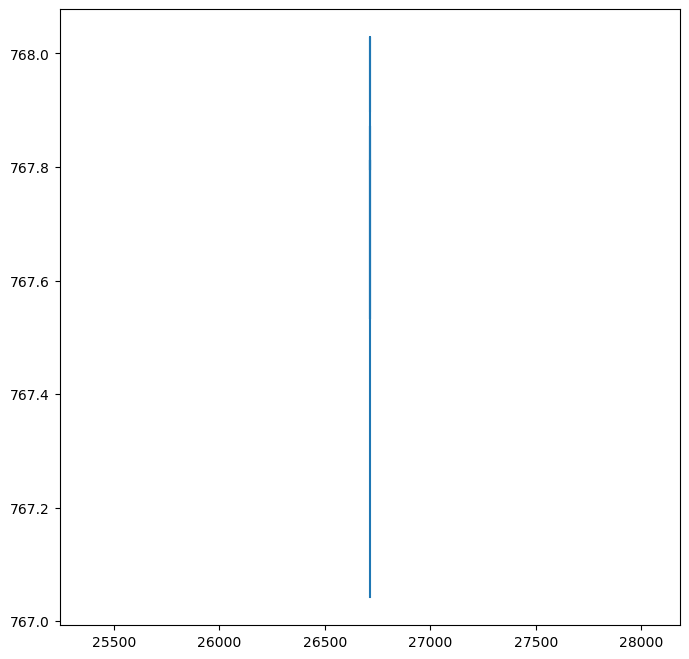

In [4]:
plt.figure(figsize=(8, 8))
plt.plot(peak_hist, step_hist)


In [5]:
peak_hist

[540.0,
 653.6842105263158,
 767.3684210526316,
 881.0526315789474,
 994.7368421052631,
 1108.421052631579,
 1222.1052631578948,
 1335.7894736842104,
 1449.4736842105262,
 1563.157894736842,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625,
 26711.86572265625]